In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torchvision import datasets as dset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Image class

In [ ]:
# google drive mount
!cp -r drive/MyDrive/GAN_prac/horse2zebra.zip ./
!unzip horse2zebra.zip
!ls

Archive:  horse2zebra.zip
replace horse2zebra/trainA/n02381460_6223.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: drive  horse2zebra  horse2zebra.zip  sample_data


In [ ]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## Layer blocks

In [ ]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True, activation='relu'):
        super(ContractingBlock, self).__init__()
        ### Conv2d : H_out = (H_in + 2*padding - dilation*(kernel_size-1)-1) /stride + 1
        self.conv1 = nn.Conv2d(input_channels, input_channels*2,
                               kernel_size=3, stride=2, padding=1, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels,
                               kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels,
                               kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [ ]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        ### Conv-Transpose2d : H_out = (H_in - 1) * stride - 2*padding + dilation*(kernel_size-1) + output_padding + 1
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2,
                                        kernel_size=3, stride=2, padding=1, output_padding=1)
        ###
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels*2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)

        return self.tanh(xn)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels*2, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels*4, activation='lrelu')
        self.final = ContractingBlock(hidden_channels*8, 1)
    

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)

        return xn

## Loss

### Discriminator loss

In [ ]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    disc_fake_X_hat = disc_X(fake_X.detach())  # D_h( G_zh(x) )
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat)) # E_x~z ( D_h(G_zh(x)) - 0 )^2
    disc_real_X_hat = disc_X(real_X) # D_h(y)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat)) # E_y~h ( D_h(y)-1 )^2
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2

    return disc_loss

### Generator loss (adv + cycle + identity)

#### Adversarial loss

In [ ]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X) # G_zh(x)
    disc_fake_Y_hat = disc_Y(fake_Y) # D( G_zh(x) )
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat)) # E_x~z( D(G_zh(x)) - 1 )^2

    return adversarial_loss, fake_Y

#### Cycle Consistency loss

In [ ]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    cycle_X = gen_YX(fake_Y) # G_hz(G_zh(x)) , fake_Y=G_zh(x)
    cycle_loss = cycle_criterion(cycle_X, real_X) # E_x~z | G_hz(G_zh(x)) - x |

    return cycle_loss, cycle_X

#### Identity loss

In [ ]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X) # G_hz(x)
    identity_loss = identity_criterion(identity_X, real_X) # E_x~z || G_hz(x) - x ||_2

    return identity_loss, identity_X

#### CycleGan loss (total loss)

In [ ]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B,
                 adv_criterion, identity_criterion, cycle_criterion,
                 lambda_identity=0.1, lambda_cycle=10):
    # Adversarial loss
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = gen_adversarial_loss + lambda_identity*gen_identity_loss + lambda_cycle*gen_cycle_loss

    return gen_loss, fake_A, fake_B


## Initialization (hyperparameters setting)

In [ ]:
# variables
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

In [ ]:
# data load
transform = transforms.Compose([
                                transforms.Resize(load_shape),
                                transforms.RandomCrop(target_shape),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("horse2zebra", transform=transform)

In [ ]:
# optimizer
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant(m.bias, 0)

gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)


## image display func

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## training

In [ ]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)
gen_losses = []
disc_A_losses = []
disc_B_losses = []


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqmd(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            
            ### Update discriminator A ###
            disc_A_opt.zero_grad()  # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            #
            disc_A_losses.append(disc_A_loss)
            #
            disc_A_loss.backward(retain_graph=True) # Update gradients
            disc_A_opt.step() # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad()  # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            #
            disc_B_losses.append(disc_B_loss)
            #
            disc_B_loss.backward(retain_graph=True) # Update gradients
            disc_B_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B,
                adv_criterion, recon_criterion, recon_criterion
            )
            gen_losses.append(gen_loss)
            
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator: (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({'gen_AB': gen_AB.state_dict(),
                                'gen_BA': gen_BA.state_dict(),
                                'gen_opt': gen_opt.state_dict(),
                                'disc_A': disc_A.state_dict(),
                                'disc_A_opt': disc_A_opt.state_dict(),
                                'disc_B': disc_B.state_dict(),
                                'disc_B_opt': disc_B_opt.state_dict()},
                               f"cycleGAN_{cur_step}.pth")
            cur_step += 1

Epoch 0: Step 0: Generator: (U-Net) loss: 0.0645679235458374, Discriminator loss: 0.003153088092803955


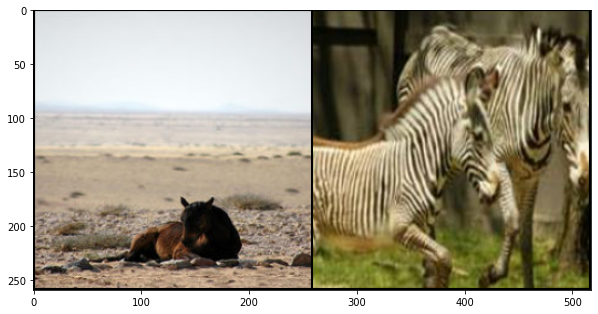

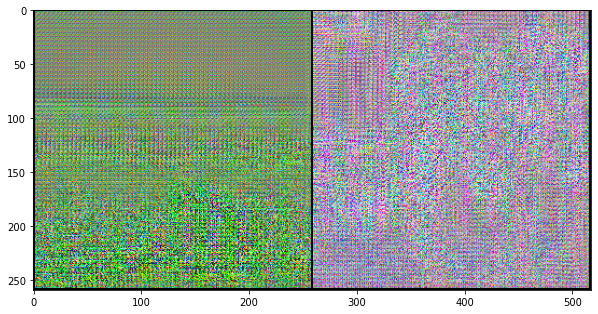

RuntimeError: ignored

In [ ]:

train()

In [1]:
%cd drive/MyDrive/KSA_AI/GAN/GAN_prac/

/content/drive/MyDrive/KSA_AI/GAN/GAN_prac


In [ ]:
!git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/nhm0819/GAN_prac.git
git push -u origin main